# COGS 108 - Final Project 

# Overview

This project explores the geospatial distribution of quantity (measured by area) and quality (measured by rating on Yelp) of parks in San Diego. The method of kernel density with weights defined by quantity and quality is used during analysis, combined with various statistical methods and visualizations. The findings are that Council District 8 seems to have both lower quantity and lower quality of parks compared to other districts.

# Name & GitHub

- Name: Chengsong Diao
- GitHub Username: o0t3ivpf

# Research Question

Are the quantity (measured by area) and quality (measured by rating on Yelp) of parks distributed equally geospatially in San Diego? If not, which districts (council districts) tend to have higher quantity and/or quality and which ones tend to have lower quantity and/or quality?

## Background and Prior Work

According to our knowledge and various studies, parks and recreation centers have significant positive impact on public health and sustainability (Rigolon). At the same time, the geospatial distribution of parks and recreation facilities and their quality may not be fair, which disadvantages low socioeconomic and ethnic minority people (Rigolon and Tarrant et al.).

Rigolon concludes that there are "striking inequities for park acreage and park quality" in cities of developed countries. I want to confirm if there are similar inequities in San Diego, and make suggestions to future city planning on parks and recreation centers, which may help improve public health and life quality of people in San Diego.

References (include links):
- 1) Rigolon, Alessandro. "A complex landscape of inequity in access to urban parks: A literature review." Landscape and Urban Planning, Volume 153, 2016, 160-169, https://doi.org/10.1016/j.landurbplan.2016.05.017.
- 2) Tarrant, Michael A., et al. "Environmental Justice and the Spatial Distribution of Outdoor Recreation sites: an Application of Geographic Information Systems." Journal of Leisure Research, 31:1, 18-34, https://doi.org/10.1080/00222216.1999.11949849.

# Hypothesis


The quantity (measured by area) and quality (measured by rating on Yelp) of parks are distributed inequally geospatially in San Diego. It is possible because there is historical discrimination against ethnic minority people and it results in different ethnic composition and wealth among communities.

# Dataset(s)

- Dataset Name: San Diego Park Locations Data
- Link to the dataset: http://seshat.datasd.org/sde/parks/parks_datasd.geojson
- Number of observations: 2769

This dataset contains the locations of parks in San Diego, where all parks are represented by polygons that represent geographical shapes.

- Dataset Name: San Diego Joint Use Parks Data
- Link to the dataset: http://seshat.datasd.org/sde/joint_use/joint_use_datasd.geojson
- Number of observations: 96

This dataset contains the locations of joint use parks in San Diego, where all joint use parks are represented by polygons that represent geographical shapes. The joint use parks are intended to provide active and passive recreational opportunities for school children when school is in session and the general public when school is not in session.

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://github.com/COGS108/individual_fa20/raw/17002cefb489881907db8f2f53575607249d3cc8/data/yelp_SD_parks.csv
- Number of observations: 833

This dataset contains the basic information of parks (including location) and aggregate ratings from Yelp users.

I will combine the first two datasets to analyze the quantity (area) distribution of parks, and use the last one to analyze the quality (Yelp rating) distribution of parks. When combining the first two datasets, I will combine by rows and check for intersections of parks (possible duplicates).

Besides, I have an additional dataset that is used for data cleaning and visualization but not for analysis:

- Dataset Name: San Diego City Council Districts
- Link to the dataset: http://seshat.datasd.org/sde/council/council_districts_datasd.geojson
- Number of observations: 9

This dataset contains the San Diego City Council Districts, which is used for removing parks that does not overlap with San Diego in the datasets. It is also used in visualization that shows potential inequities in quantity and quality distribution among districts in San Diego.

# Setup

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

# Data Cleaning

First, load the map that contains council districts of San Diego.

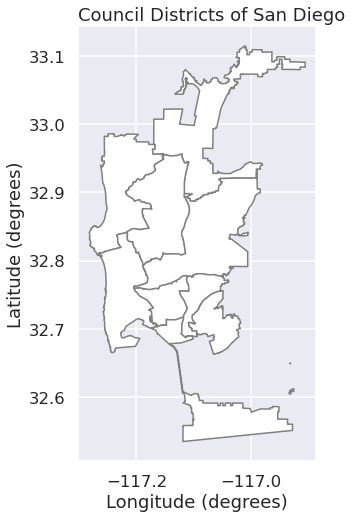

In [2]:
df_sd = gpd.read_file('./data_inc/council_districts_datasd.geojson')
df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Council Districts of San Diego', loc='left')
plt.show()

The districts are shown in polygons with white filling and grey boundary in the above figure.

Then, clean the data in the first three datasets: San Diego Park Locations Data, San Diego Recreation Center Locations Data, and San Diego Joint Use Parks Data. Since I only want to analyze the parks and recreation centers in San Diego, I have to remove those that does not overlap with the map of San Diego above, i.e. those that are completely out of the boundary of San Diego.

## San Diego Park Locations Data

In [3]:
df_parks = gpd.read_file('./data/parks_datasd.geojson')
print('# entries:', df_parks.shape[0])

# entries: 2769


Plot the positions of parks on the map:

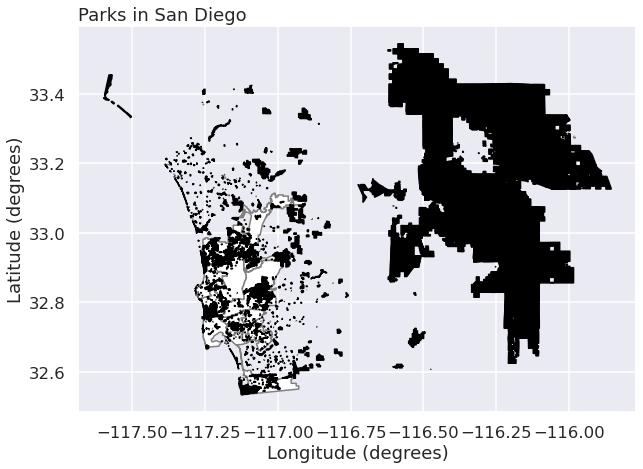

In [4]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_parks.plot(ax=ax, color='black', edgecolor='black')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Parks in San Diego', loc='left')
plt.show()

The parks are shown as black-filled polygons in the above figure.

As shown above, there are large state parks that are out of the boundary of San Diego in this dataset. I will remove these entries.

In [5]:
df_parks = df_parks[df_parks['objectid'].apply(lambda x: not gpd.overlay(df_parks[df_parks['objectid'] == x], df_sd[['geometry']], how='intersection').empty)]
print('# entries (cleaned):', df_parks.shape[0])

# entries (cleaned): 2184


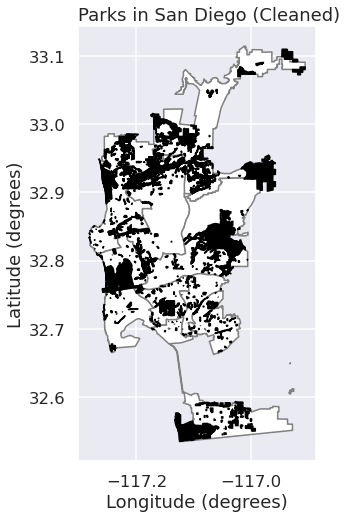

In [6]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_parks.plot(ax=ax, color='black', edgecolor='black')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Parks in San Diego (Cleaned)', loc='left')
plt.show()

The parks after cleaning are shown as black-filled polygons in the above figure.

Now, I have removed all parks that are out of San Diego (as shown in the above figure). Check if there are duplicate entries (parks with roughly the same shape and area at almost the same position):

In [7]:
entries = df_parks.shape[0]
duplicates = []
for i in range(entries - 1):
    for j in range(i + 1, entries):
        if abs(df_parks.iloc[i]['gis_acres'] - df_parks.iloc[j]['gis_acres']) < 0.1:
            if df_parks.iloc[i]['geometry'].centroid.distance(df_parks.iloc[j]['geometry'].centroid) < 1e-4:
                duplicates.append([df_parks.iloc[i]['objectid'], df_parks.iloc[j]['objectid']])
    if i % 10 == 0:
        print('Completed', i, ':', len(duplicates), end='\r')
duplicates

[[613, 1470],
 [713, 757],
 [729, 1223],
 [1031, 1199],
 [1031, 2066],
 [1148, 2398],
 [1172, 2472],
 [1238, 1949],
 [1392, 2066],
 [1472, 1896],
 [1473, 2398],
 [1475, 2389],
 [1509, 1648],
 [1509, 2062],
 [1699, 2087],
 [1731, 1918],
 [1738, 2122],
 [2041, 2062],
 [2203, 2472]]

I found 19 potential duplicates, with the following list of objectid's:
[[613, 1470],
 [713, 757],
 [729, 1223],
 [1031, 1199],
 [1031, 2066],
 [1148, 2398],
 [1172, 2472],
 [1238, 1949],
 [1392, 2066],
 [1472, 1896],
 [1473, 2398],
 [1475, 2389],
 [1509, 1648],
 [1509, 2062],
 [1699, 2087],
 [1731, 1918],
 [1738, 2122],
 [2041, 2062],
 [2203, 2472]]

Then, check if they really overlaps with each other:

In [8]:
duplicates_backup = duplicates
duplicates = []
for a, b in duplicates_backup:
    s1 = df_parks[df_parks['objectid'] == a]['geometry'].values[0]
    s2 = df_parks[df_parks['objectid'] == b]['geometry'].values[0]
    if s1.intersects(s2) and not s1.touches(s2):
        duplicates.append([a, b])
duplicates

[[613, 1470], [713, 757], [729, 1223]]

The only real duplicates are entries with these objectid's: [[613, 1470], [713, 757], [729, 1223]]

Verify one by one below:

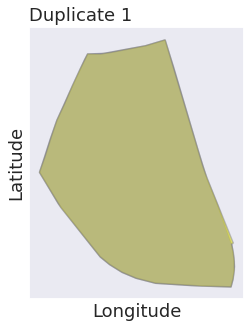

In [9]:
ax = df_parks[df_parks['objectid'] == 613].plot(color='blue', edgecolor='grey', alpha=0.5, figsize=(8, 5))
df_parks[df_parks['objectid'] == 1470].plot(ax=ax, color='yellow', edgecolor='grey', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks([])
plt.yticks([])
plt.title('Duplicate 1', loc='left')
plt.show()

The two potential duplicate areas are shown in yellow and blue filled (semi-transparent) polygons in the above graph. They almost completely overlap, so the combined color seems grey. The same coloring applies to the following two figures.

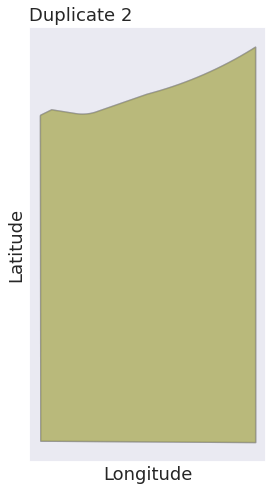

In [10]:
ax = df_parks[df_parks['objectid'] == 713].plot(color='blue', edgecolor='grey', alpha=0.5)
df_parks[df_parks['objectid'] == 757].plot(ax=ax, color='yellow', edgecolor='grey', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks([])
plt.yticks([])
plt.title('Duplicate 2', loc='left')
plt.show()

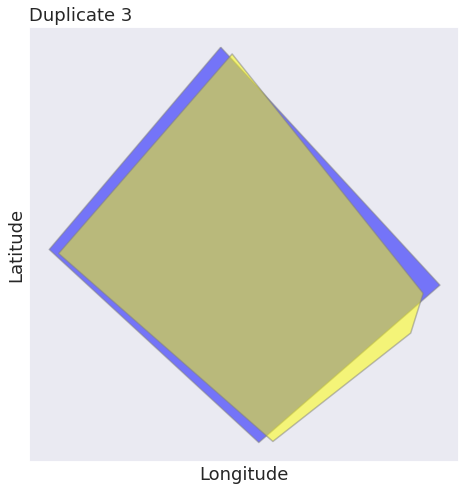

In [11]:
ax = df_parks[df_parks['objectid'] == 729].plot(color='blue', edgecolor='grey', alpha=0.5)
df_parks[df_parks['objectid'] == 1223].plot(ax=ax, color='yellow', edgecolor='grey', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks([])
plt.yticks([])
plt.title('Duplicate 3', loc='left')
plt.show()

The above are indeed duplicates. Thus, I remove the duplicated entries from the dataset as well.

In [12]:
df_parks.drop(list(df_parks[df_parks['objectid'].apply(lambda x: x == 1470 or x == 757 or x == 1223)].index), inplace=True)
df_parks.reset_index(inplace=True)

In [13]:
print('# entries (cleaned):', df_parks.shape[0])

# entries (cleaned): 2181


## San Diego Joint Use Parks Data

In [14]:
df_joint = gpd.read_file('./data/joint_use_datasd.geojson')
print('# entries:', df_joint.shape[0])

# entries: 96


Plot the positions of parks on the map:

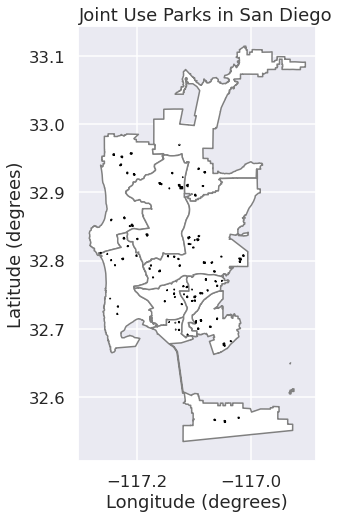

In [15]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_joint.plot(ax=ax, color='black', edgecolor='black')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Joint Use Parks in San Diego', loc='left')
plt.show()

The joint use parks are represented by black-filled polygons in the above figure. Since the polygons are small, they are like black dots.

It seems that there are no joint use parks out of the boundary of San Diego, but I need to confirm this. Test if there are joint use parks out of boundary of San Diego:

In [16]:
df_joint = df_joint[df_joint['objectid'].apply(lambda x: not gpd.overlay(df_joint[df_joint['objectid'] == x], df_sd[['geometry']], how='intersection').empty)]
print('# entries (cleaned):', df_joint.shape[0])

# entries (cleaned): 96


Since there are no decrease in the number of entries, all joint use parks in the dataset are valid as they are inside San Diego or overlap with the boundary of San Diego.

There are two area columns indicating city-owned land and district-owned land, so assign a new column that calculate the sum of these two to get the total area.

In [17]:
df_joint = df_joint.assign(total_acres=df_joint['city_acres'] + df_joint['dist_acres'])

Next, check if there are possible duplicate entries. 

In [18]:
entries = df_joint.shape[0]
duplicates = []
for i in range(entries - 1):
    for j in range(i + 1, entries):
        if abs(df_joint.iloc[i]['total_acres'] - df_joint.iloc[j]['total_acres']) < 0.1:
            if df_joint.iloc[i]['geometry'].centroid.distance(df_joint.iloc[j]['geometry'].centroid) < 1e-4:
                duplicates.append([df_joint.iloc[i]['objectid'], df_joint.iloc[j]['objectid']])
    if i % 10 == 0:
        print('Completed', i, ':', len(duplicates), end='\r')
duplicates

[]

There seems to be no duplicates. The datasets are ready for combine.

## Combine the first two datasets

First, create a new dataset based on columns from San Diego park locations dataset.

In [19]:
df_all = df_parks[['objectid', 'name', 'alias', 'gis_acres', 'geometry']]

Combine the Joint Use Parks data into the new dataset.

In [20]:
overlaps = {}
for i in range(df_joint.shape[0]):
    s1 = df_joint.iloc[i]['geometry']
    for j in range(df_parks.shape[0]):
        s2 = df_parks.iloc[j]['geometry']
        if s1.intersects(s2) and not s1.touches(s2):
            overlaps[df_joint.iloc[i]['objectid']] = df_parks.iloc[j]['objectid']
overlaps

{2087: 481,
 2090: 489,
 2092: 409,
 2095: 755,
 2103: 477,
 2106: 528,
 2108: 410,
 2110: 457,
 2113: 590,
 2126: 1566,
 2128: 580,
 2129: 759,
 2133: 431,
 2137: 607,
 2142: 479,
 2150: 468,
 2152: 712,
 2153: 566,
 2154: 670,
 2156: 593,
 2157: 498,
 2161: 434,
 2162: 1436,
 2163: 2378,
 2164: 516,
 2165: 642,
 2167: 711,
 2171: 621,
 2174: 429,
 2177: 1708}

There are many entries in the joint use parks dataset that have overlapped areas with some entries in the park locations dataset. An example is shown below.

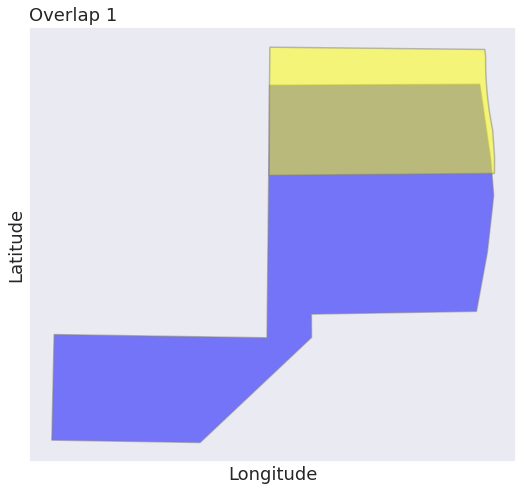

In [21]:
ax = df_joint[df_joint['objectid'] == 2087].plot(color='blue', edgecolor='grey', alpha=0.5)
df_parks[df_parks['objectid'] == 481].plot(ax=ax, color='yellow', edgecolor='grey', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks([])
plt.yticks([])
plt.title('Overlap 1', loc='left')
plt.show()

The two areas that overlap with each other are filled with blue and yellow (semi-transparent) respectively in the above figure.

I will handle these entries by combining the polygon with union and replace the original polygon in the corresponding entries in the new dataset. For other entries, I will add them as new rows in the new dataset.

In [22]:
for i in range(df_joint.shape[0]):
    objectid = df_joint.iloc[i]['objectid']
    if objectid in overlaps:
        s1 = df_all[df_all['objectid'] == overlaps[objectid]]['geometry'].values[0]
        s2 = df_joint.iloc[i]['geometry']
        df_all[df_all['objectid'] == overlaps[objectid]]['geometry'] = shapely.ops.unary_union([s1, s2])
    else:
        objectid += 1000 # to prevent duplicates
        name = df_joint.iloc[i]['name']
        alias = df_joint.iloc[i]['facility']
        gis_acres = df_joint.iloc[i]['total_acres']
        geometry = df_joint.iloc[i]['geometry']
        df_all = df_all.append({'objectid': objectid, 'name': name, 'alias': alias, 'gis_acres': gis_acres, 'geometry': geometry}, ignore_index=True)

In [23]:
df_all['objectid'].duplicated().any()

False

The final combined dataset has 2247 entries.

In [24]:
df_all

,objectid,name,alias,gis_acres,geometry
0,2,Torrey Pines SB,Torrey Pines State Beach,67.294309,"POLYGON ((-117.26147 32.93883, -117.26181 32.9..."
1,3,Ruocco Park,Ruocco Park,3.312526,"POLYGON ((-117.17298 32.71167, -117.17303 32.7..."
2,4,Tuna Harbor Park,Tuna Harbor Park,0.639035,"POLYGON ((-117.17260 32.71160, -117.17268 32.7..."
3,5,San Diego Bayfront Park,San Diego Bayfront Park,3.669272,"MULTIPOLYGON (((-117.16074 32.70407, -117.1594..."
4,11,San Pasqual Battlefield SHP,San Pasqual Battlefield State Park,70.704243,"POLYGON ((-116.98086 33.08869, -116.98056 33.0..."
...,...,...,...,...,...
2242,3178,Linda Vista Elementary,Linda Vista Elementary,2.270000,"POLYGON ((-117.17422 32.79248, -117.17421 32.7..."
2243,3179,Marvin Elementary,Marvin Elementary,3.870000,"POLYGON ((-117.06939 32.79648, -117.06934 32.7..."
2244,3180,Cubberely Elementary,Cubberley Elementary,3.650000,"POLYGON ((-117.12709 32.80168, -117.12696 32.8..."
2245,3181,Encanto Elementary,Encanto Elementary,2.430000,"POLYGON ((-117.05957 32.71460, -117.05957 32.7..."


Visualize the combined dataset of parks on the San Diego districts map:

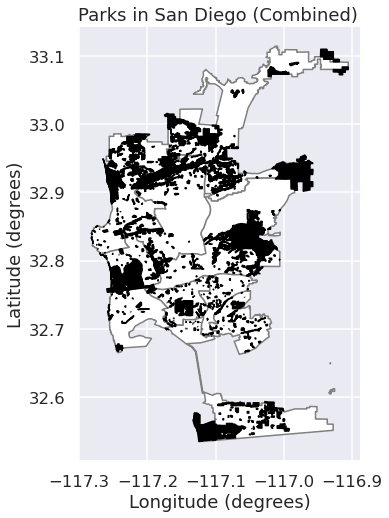

In [25]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_all.plot(ax=ax, color='black', edgecolor='black')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Parks in San Diego (Combined)', loc='left')
plt.show()

The parks in the combined dataset are visualized as black-filled polygons in the above figure.

## San Diego Parks Yelp Data

In [26]:
df_yelp_raw = pd.read_csv('./data/yelp_SD_parks.csv', dtype={'phone': str, 'id': str, 'review_count': int})
df_yelp_raw

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",16192390512,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",16192327275,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False
...,...,...,...,...,...,...,...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",16192869313,ggbc59hSsl6pxCGSN1QLQA,https://www.yelp.com/biz/del-cerro-san-diego-s...,4.5,12,-117.073524,32.792626,False
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",16192380100,c8jhIMcwSjWqBD7S-faKYg,https://www.yelp.com/biz/san-diego-metropolita...,2.5,268,-117.153400,32.705760,False
830,Petco Park,"100 Park Blvd San Diego, CA 92101",16197955000,HkgSbRLVMRHExsRkImIK5A,https://www.yelp.com/biz/petco-park-san-diego?...,4.0,1667,-117.157054,32.707246,False
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",17604342824,wYGJ65iVMi74-3TylWxY0Q,https://www.yelp.com/biz/ann-d-l-heureux-memor...,3.0,50,-117.316419,33.171137,False


Check if critical variables have missing values:

In [27]:
df_yelp_raw[['name', 'id', 'rating', 'longitude', 'latitude']].isna().any()

name         False
id           False
rating       False
longitude     True
latitude      True
dtype: bool

In [28]:
df_yelp_raw[(df_yelp_raw['longitude'].isna()) | (df_yelp_raw['latitude'].isna())]

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
226,Officer Christopher Wilson Memorial Park,"San Diego, CA",NaN,fg97iBKVfgNgf3ehS6Rkvw,https://www.yelp.com/biz/officer-christopher-w...,4.0,1,NaN,NaN,False


Since geospatial analysis is impossible without geospatial position, I have to remove this entry.

In [29]:
df_yelp_raw.drop(list(df_yelp_raw[(df_yelp_raw['longitude'].isna()) | (df_yelp_raw['latitude'].isna())].index), inplace=True)
df_yelp_raw.reset_index(inplace=True)

Check if there are (permanently) closed parks.

In [30]:
df_yelp_raw[df_yelp_raw['is_closed'] == True]

,index,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
801,802,Saratoga Park,"10375-10399 Vernon Ave Montclair, CA 91763",NaN,pwFFBxMC3ZLEQAQZ0lJrGQ,https://www.yelp.com/biz/saratoga-park-montcla...,5.0,1,-117.686431,34.064903,True


There is one entry in which the park is (permanently) closed. Remove this entry.

In [31]:
df_yelp_raw.drop(list(df_yelp_raw[df_yelp_raw['is_closed'] == True].index), inplace=True)
df_yelp_raw.reset_index(inplace=True)

Remove all useless columns from the dataset.

In [32]:
df_yelp_raw = df_yelp_raw[['name', 'id', 'rating', 'longitude', 'latitude']]
df_yelp_raw

,name,id,rating,longitude,latitude
0,Balboa Park,9M_FW_-Ipx93I36w-_ykBg,5.0,-117.153150,32.734502
1,Civita Park,3AEHjqNrTmggA6G9VdhQfg,4.5,-117.147278,32.778315
2,Waterfront Park,3unbJeYrn1RmInZGmjp80g,4.5,-117.172479,32.721952
3,Trolley Barn Park,PvHxIYrmaiFKdWUDTMDzcg,4.5,-117.143789,32.762463
4,Bay View Park,6IF4VB9-fkv_F-LBvG8ppQ,5.0,-117.178967,32.701785
...,...,...,...,...,...
826,Del Cerro - San Diego,ggbc59hSsl6pxCGSN1QLQA,4.5,-117.073524,32.792626
827,San Diego Metropolitan Transit System,c8jhIMcwSjWqBD7S-faKYg,2.5,-117.153400,32.705760
828,Petco Park,HkgSbRLVMRHExsRkImIK5A,4.0,-117.157054,32.707246
829,Ann D. L'Heureux Memorial Dog Park,wYGJ65iVMi74-3TylWxY0Q,3.0,-117.316419,33.171137


Check if there are duplicate id's.

In [33]:
df_yelp_raw[df_yelp_raw['id'].duplicated()]

,name,id,rating,longitude,latitude
169,Colina Park Golf Course,#NAME?,4.5,-117.083427,32.751038
180,Memorial Park,#NAME?,3.5,-117.878387,33.719057
269,Belmont Park,#NAME?,4.0,-117.251080,32.769930
303,The New Children's Museum,#NAME?,3.5,-117.165150,32.710660
312,Ocean View Hills Neighborhood Park,#NAME?,4.0,-117.026600,32.581960
339,The Shops at La Jolla Village,#NAME?,3.0,-117.233726,32.868381
389,Ghosts & Gravestones Tour San Diego,#NAME?,3.0,-117.195798,32.753567
503,Lakeview Trail,#NAME?,3.5,-117.185371,33.118561
542,Guadalupana Memorial Chapel,#NAME?,5.0,-117.137980,32.706070
581,David's Friendly Market,#NAME?,5.0,-117.125080,32.711420


Replace all id's with index + 1.

In [34]:
df_yelp_raw['id'] = df_yelp_raw.index + 1

Create GeoDataFrame based on this DataFrame.

In [35]:
df_yelp = gpd.GeoDataFrame(df_yelp_raw, geometry=gpd.points_from_xy(df_yelp_raw.longitude, df_yelp_raw.latitude))
df_yelp = df_yelp[['name', 'id', 'rating', 'geometry']]
df_yelp

,name,id,rating,geometry
0,Balboa Park,1,5.0,POINT (-117.15315 32.73450)
1,Civita Park,2,4.5,POINT (-117.14728 32.77831)
2,Waterfront Park,3,4.5,POINT (-117.17248 32.72195)
3,Trolley Barn Park,4,4.5,POINT (-117.14379 32.76246)
4,Bay View Park,5,5.0,POINT (-117.17897 32.70179)
...,...,...,...,...
826,Del Cerro - San Diego,827,4.5,POINT (-117.07352 32.79263)
827,San Diego Metropolitan Transit System,828,2.5,POINT (-117.15340 32.70576)
828,Petco Park,829,4.0,POINT (-117.15705 32.70725)
829,Ann D. L'Heureux Memorial Dog Park,830,3.0,POINT (-117.31642 33.17114)


Check duplicates (points at the same place).

In [36]:
df_yelp[df_yelp['geometry'].duplicated()]

,name,id,rating,geometry
122,Kearny Mesa Park & Recreation Center,123,4.0,POINT (-117.16762 32.79994)
221,Electra Bike Forums,222,4.0,POINT (-117.16431 32.72110)
234,Allied Gardens Recreational Center,235,3.0,POINT (-117.07956 32.79574)
325,Kellogg Park,326,5.0,POINT (-117.25719 32.85623)
381,Haunted San Diego Ghost Tours,382,4.5,POINT (-117.19379 32.75164)
404,White Deer Park,405,5.0,POINT (-117.19523 32.75671)
437,Internal Revenue Service,438,4.0,POINT (-117.16431 32.72110)
646,Sandburg Child Development Center,647,4.0,POINT (-117.14980 32.92618)
720,The Godfather Restaurant,721,4.0,POINT (-117.15168 32.83326)
743,California Creative Kids,744,5.0,POINT (-117.16431 32.72110)


Although there are several points at the same place, it does not interfere with our analysis, since the ratings may be different for two entries at the same place and it is reasonable that quality is different for a park and its recreation center. I decide to leave them as is.

Next, check if all parks are within the boundary of San Diego.

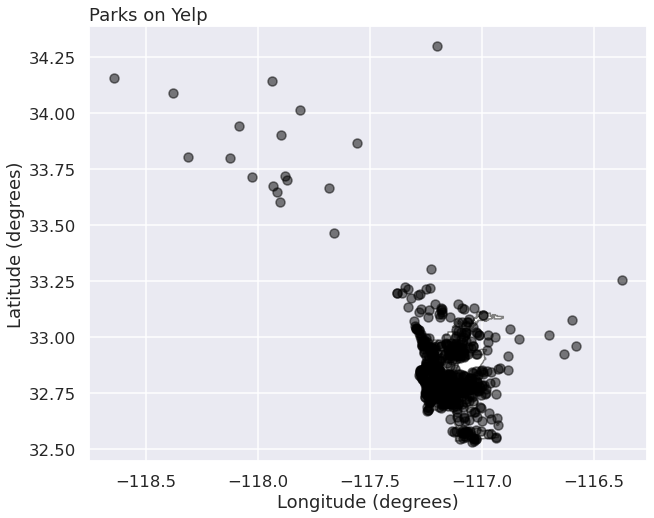

In [37]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_yelp.plot(ax=ax, color='black', alpha=0.5)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Parks on Yelp', loc='left')
plt.show()

The positions of the parks on Yelp are shown as black dots in the above figure.

Remove all entries with position out of San Diego:

In [38]:
df_yelp = df_yelp[df_yelp['id'].apply(lambda x: not gpd.overlay(df_yelp[df_yelp['id'] == x], df_sd[['geometry']], how='intersection', keep_geom_type=False).empty)]
print('# entries (cleaned):', df_yelp.shape[0])

# entries (cleaned): 664


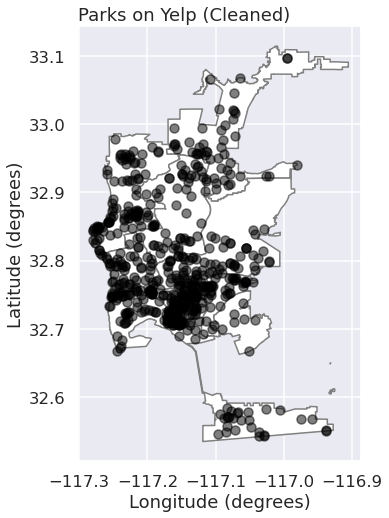

In [39]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_yelp.plot(ax=ax, color='black', alpha=0.5)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Parks on Yelp (Cleaned)', loc='left')
plt.show()

The positions of the parks on Yelp after cleaning are shown as black dots in the above figure.

# Data Analysis & Results

## Quantity (Areas) of Parks

The distribution of areas of the parks in San Diego:

In [40]:
df_all['gis_acres'].describe()

count    2247.000000
mean       20.807417
std       130.547409
min         0.004650
25%         0.486286
50%         2.901194
75%        10.890656
max      4108.397150
Name: gis_acres, dtype: float64

In [41]:
(df_all['gis_acres'] <= 10).sum()

1645

In [42]:
(df_all['gis_acres'] > 1000).sum()

8

From the initial analysis, I know that most parks have areas less than 10 acres, while there are 8 parks with areas larger than 1000 acres. These outliers may alone make a huge difference in quantity (area) of parks available in some regions than other regions.

The main method for measurement of quantity (area) of parks available to specific regions is kernel density, where the density value is weighted by the areas of nearby parks. In other words, the total area of nearby parks are the weights instead of the number of parks.

The model generated by kernel density method is reasonable because for people in a specific region, they often visit places around their neighborhoods. It is also considered relatively convenient for people to go to parks near their home (e.g. within 1 mile).

Since 1 degree in latitude is approximately 69 miles and 1 degree in longitude is approximately 53 miles around 40 degrees north, I decide to use raster cells with 0.01 degrees x 0.01 degrees and kernels with 0.03 degrees x 0.03 degrees. (0.03 degrees in latitude is about 2.07 miles and 0.03 degrees in longitude is shorter.)

In [43]:
# limits for longitude and latitude
lo_l = -117.3
lo_h = -116.9
la_l = 32.52
la_h = 33.14

cell_sz = 0.01
kernel_sz = 0.03

In [44]:
def compute_kernel(df, col, avg):
    res = gpd.GeoDataFrame(columns=['districts', 'value'], geometry=[])
    df_sd_t = df_sd[['district', 'geometry']]
    exp_sz = (lo_h - lo_l) * (la_h - la_l) / (cell_sz ** 2)
    count = 0
    print('Started', end='\r')
    i = lo_l
    j = la_l
    while i < lo_h:
        while j < la_h:
            cell = Polygon([[i, j], [i + cell_sz, j], [i + cell_sz, j + cell_sz], [i, j + cell_sz], [i, j]])
            temp = gpd.overlay(gpd.GeoDataFrame(geometry=[cell]), df_sd_t, how='intersection')
            if not temp.empty:
                districts = list(temp['district'])
                geom = shapely.ops.unary_union(list(temp['geometry']))
                diff = 0.5 * (kernel_sz - cell_sz)
                cell = Polygon([[i - diff, j - diff], [i + cell_sz + diff, j - diff], [i + cell_sz + diff, j + cell_sz + diff], [i - diff, j + cell_sz + diff], [i - diff, j - diff]])
                temp = gpd.overlay(gpd.GeoDataFrame(geometry=[cell]), df, how='intersection', keep_geom_type=False)
                vals = list(temp[col])
                value = sum(vals)
                if avg and value != 0:
                    value /= len(vals)
                res = res.append({'districts': districts, 'value': value, 'geometry': geom}, ignore_index=True)
            j += cell_sz
            count += 1
            print('Processing:', '%.2f%%' % (count * 100 / exp_sz), end='\r')
        i += cell_sz
        j = la_l
    print('\nCompleted')
    return res

In [45]:
df_areas = compute_kernel(df_all, 'gis_acres', False)

Processing: 101.61%
Completed


In [46]:
df_areas['value'].describe()

count    1042.000000
mean      910.059715
std      1269.201647
min         0.000000
25%        70.704243
50%       352.301004
75%      1138.736982
max      5289.288885
Name: value, dtype: float64

In [47]:
(df_areas['value'] == 0).sum()

127

There are 127 cells in the 1042 cells having no areas of parks, meaning that there are no parks nearby in these cells.

The distribution of areas of parks available in the raster cells:

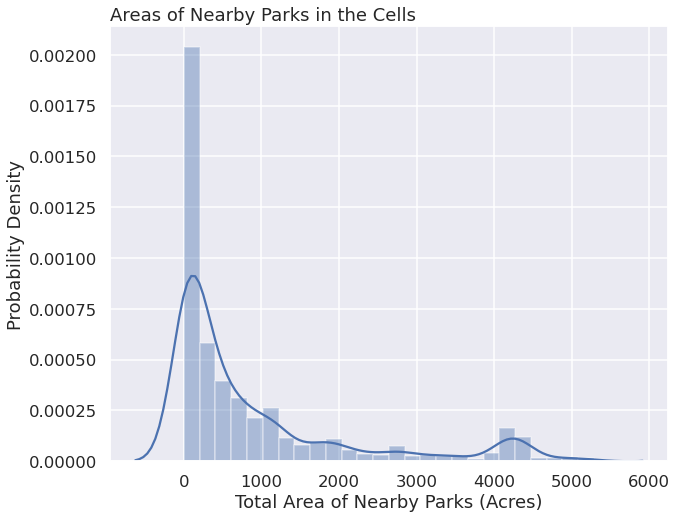

In [48]:
sns.distplot(df_areas['value'])
plt.xlabel('Total Area of Nearby Parks (Acres)')
plt.ylabel('Probability Density')
plt.title('Areas of Nearby Parks in the Cells', loc='left')
plt.show()

As I estimated before, the figure above shows that there are some outliers with extremely large values. It may lead to difficulty in visualizating the distribution on the map, so I decide to take natural logarithm (logarithm in base e) of the values before plotting on the map.

In [49]:
df_areas_plot = df_areas.assign(value_log=df_areas['value'].apply(lambda x: np.log(x)))
df_areas_plot = df_areas_plot[df_areas_plot['value'] > 0]

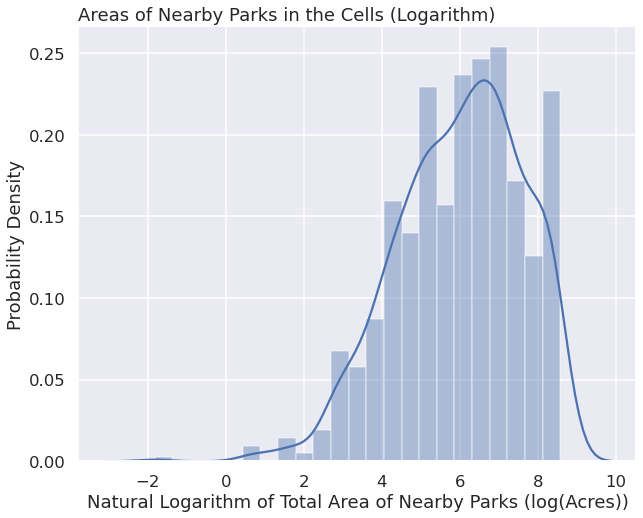

In [50]:
sns.distplot(df_areas_plot['value_log'])
plt.xlabel('Natural Logarithm of Total Area of Nearby Parks (log(Acres))')
plt.ylabel('Probability Density')
plt.title('Areas of Nearby Parks in the Cells (Logarithm)', loc='left')
plt.show()

After taking the logarithm, the distribution shown in the above graph is more suitable for visualization, since the range of values are small.

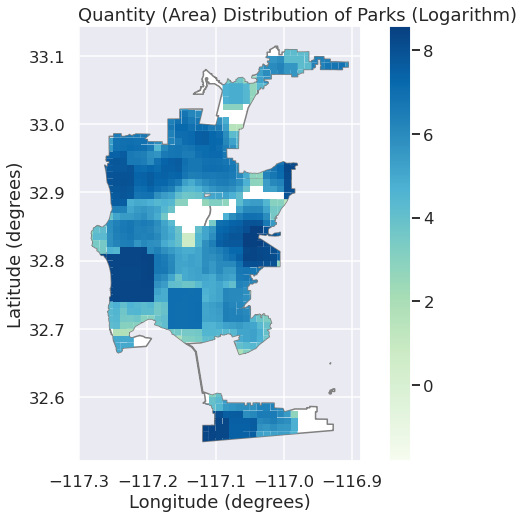

In [51]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_areas_plot.plot(ax=ax, column='value_log', edgecolor='None', cmap='GnBu', legend=True)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Quantity (Area) Distribution of Parks (Logarithm)', loc='left')
plt.show()

In the above figure, white regions are those without nearby parks and darker color means higher quantity (areas of nearby parks). It is clear that the areas of nearby parks are not distributed equally in San Diego among different regions.

Then, I want to find out if there are significant differences of quantity (area) distribution of parks among differnt council districts of San Diego. Since there are outliers with large values, I use medians instead of means.

In [52]:
df_areas_sp = pd.DataFrame(columns=['district', 'value'])
for i in range(df_areas.shape[0]):
    for j in df_areas.iloc[i]['districts']:
        df_areas_sp = df_areas_sp.append({'district': j, 'value': df_areas.iloc[i]['value']}, ignore_index=True)
df_areas_sp['district'] = df_areas_sp['district'].astype(int)

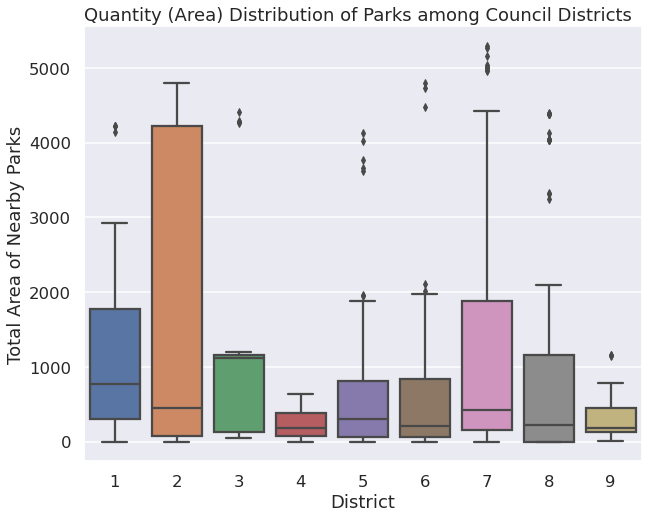

In [53]:
sns.boxplot(x='district', y='value', data=df_areas_sp)
plt.xlabel('District')
plt.ylabel('Total Area of Nearby Parks')
plt.title('Quantity (Area) Distribution of Parks among Council Districts', loc='left')
plt.show()

Through the figure above, I conclude that District 3 has the highest median of quantity of parks (measured by total areas of nearby parks), larger than 1000 acres. District 8 has more than 25% of regions that do not have nearby parks.

Maybe the city should plan for adding more parks in District 8, which will be beneficial for people's life quality and physical health there.

## Quality (Ratings) of Parks

The distribution of ratings of parks in San Diego:

In [54]:
df_yelp['rating'].describe()

count    664.000000
mean       4.044428
std        0.790631
min        1.000000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

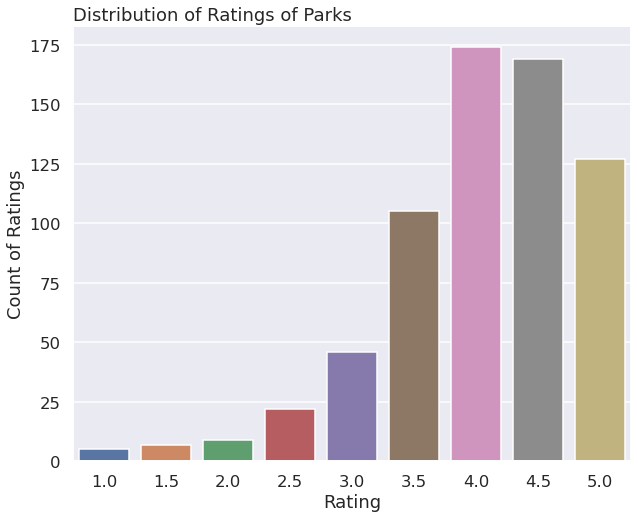

In [55]:
sns.countplot(df_yelp['rating'])
plt.xlabel('Rating')
plt.ylabel('Count of Ratings')
plt.title('Distribution of Ratings of Parks', loc='left')
plt.show()

Through the above graph, I know that the ratings have skewed distribution (skew to the left) ranging from 1.0 to 5.0, with step size 0.5. Most of the ratings are from 3.5 to 5.0.

The analysis is to compute the average ratings of nearby parks in each region to determine the quality of nearby parks. The method is still kernel density, and the reason is similar to the quantity analysis. The raster cell size and kernel size is the same as those in the quantity analysis.

In [56]:
df_ratings = compute_kernel(df_yelp, 'rating', True)

Processing: 101.61%
Completed


In [57]:
df_ratings['value'].describe()

count    1042.000000
mean        3.086815
std         1.790251
min         0.000000
25%         2.500000
50%         4.000000
75%         4.277778
max         5.000000
Name: value, dtype: float64

In [58]:
(df_ratings['value'] == 0).sum()

247

There are 247 cells in 1042 cells that have no ratings for nearby parks, meaning that there are no nearby parks or the ratings of nearby parks are not available in the Yelp dataset.

The distribution of average ratings in the raster cells:

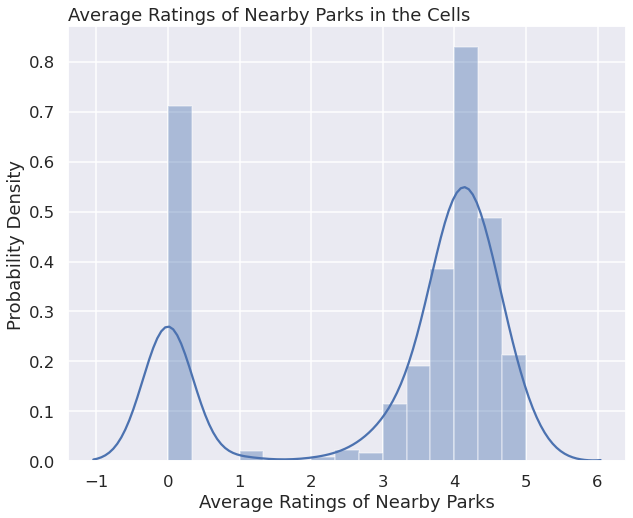

In [59]:
sns.distplot(df_ratings['value'])
plt.xlabel('Average Ratings of Nearby Parks')
plt.ylabel('Probability Density')
plt.title('Average Ratings of Nearby Parks in the Cells', loc='left')
plt.show()

The above figure shows a bimodal distribution. There are one concentration of values 0 (no ratings), and another of other values (with ratings). If 0 values are removed, the values are mostly concentrated around 4.0.

Visualize the distribution on the map:

In [60]:
df_ratings_plot = df_ratings[df_ratings['value'] > 0]

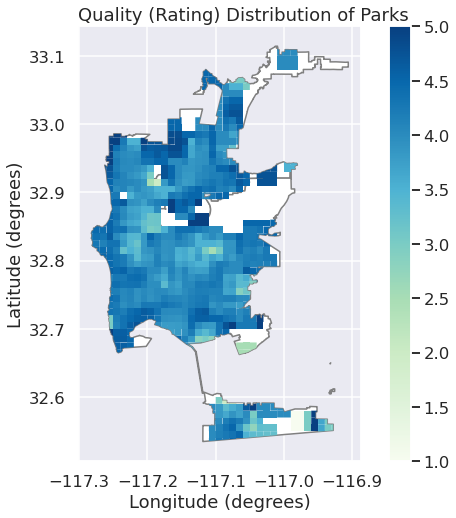

In [61]:
ax = df_sd.plot(color='white', edgecolor='grey', figsize=(10, 8))
df_ratings_plot.plot(ax=ax, column='value', edgecolor='None', cmap='GnBu', legend=True)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Quality (Rating) Distribution of Parks', loc='left')
plt.show()

In the above graph, white regions are those with missing ratings, either because there are no parks nearby or nearby parks do not have ratings in the Yelp dataset. The quality (rating) of parks are also not distributed equally geospatially in San Diego.

Then, I want to find out if there are significant differences of quality (rating) distribution of parks among differnt council districts of San Diego. By comparing this figure with the figure in the quantity analysis, there are many new white regions in the quality (rating) distribution figure. It is probably because many parks do not have ratings in the Yelp dataset. To make comparison fairer, I decide to remove the cells without ratings when calculating the statistics.

In [62]:
df_ratings_sp = pd.DataFrame(columns=['district', 'value'])
for i in range(df_ratings.shape[0]):
    for j in df_ratings.iloc[i]['districts']:
        if df_ratings.iloc[i]['value'] > 0:
            df_ratings_sp = df_ratings_sp.append({'district': j, 'value': df_ratings.iloc[i]['value']}, ignore_index=True)
df_ratings_sp['district'] = df_ratings_sp['district'].astype(int)

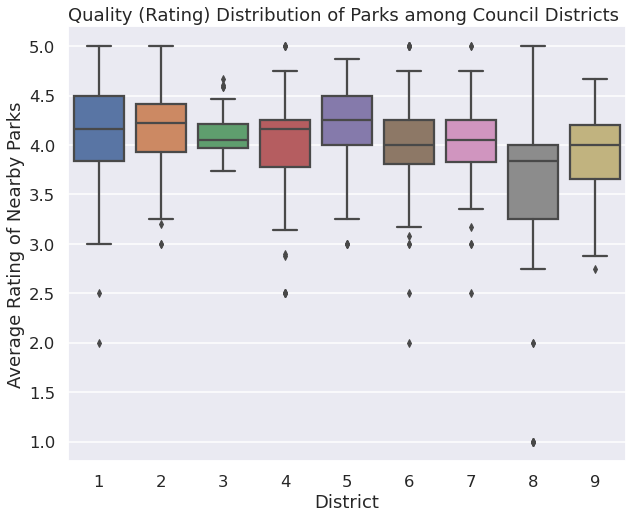

In [63]:
sns.boxplot(x='district', y='value', data=df_ratings_sp)
plt.xlabel('District')
plt.ylabel('Average Rating of Nearby Parks')
plt.title('Quality (Rating) Distribution of Parks among Council Districts', loc='left')
plt.show()

From the figure above, I find that most districts have medians between 4.0 and 4.25. District 5 has the highest median of average ratings of parks. The only District where the median is below 4.0 is District 8, and the middle 50% of average ratings are obviously lower than that of other districts.

Combined with our quantity analysis before, District 8 seems to have the least areas of nearby parks and the lowest ratings of nearby parks. Maybe the city should also consider improving the quality of existing parks in District 8.

# Ethics & Privacy

The datasets I used in this project all come from the github repo (https://github.com/COGS108/individual_fa20) collected by Professor Ellis. It includes data from the City of San Diego Open Data Portal and Yelp. The additional dataset for visualization comes from the City of San Diego Open Data Portal. I have permission to use all of these datasets.

There are no privacy concerns for using the datasets in this project, since they contain no personal information. All data are publicly available.

There may be potential biases in the Yelp dataset. The rating may not be completely objective, and many parks have very few reviews (<5), which may indicate insufficient feedbacks to represent the local population. Additionally, many parks do not have ratings available in the Yelp dataset. It makes the quality analysis only applicable to parks with ratings in the Yelp dataset, which may not be representative for the population of parks in San Diego.

In my analysis, I try my best to clean the datasets, including removing duplicate areas to prevent them from interfering with quantity (area) analysis and removing all parks that are permanently closed or out of San Diego. However, because of the lack of appropriate datasets and time, I do not take population density into consideration. To make the analysis more useful for city planning, the quantity should be measured by areas of nearby parks per person. Currently, the quantity measure is biased, especially for those regions with significantly higher or lower popuplation density. Besides, the shape and size of raster cells and kernels used in the method of kernel density are a little susceptible to MAUP.

The question I asked in this project is ethical because its purpose is to analyze the access to parks (in both quantity and quality aspects) and propose suggestions for city planning of parks and recreation centers. It is for benefiting the life quality and public health of people in San Diego. There is no discrimination against any ethnic groups or any regions. However, the conclusion of this project requires further investigation before being used practically, as there are biased in the datasets and analysis discussed before. In addition, different groups of people may have different need for specific kinds of parks and recreation facilities, which is not included in the analysis of this project. Decisions made based on conclusions in this project may unintentionally affect some groups of people more than other groups.

# Conclusion & Discussion

The quantity (measured by area) and quality (measured by rating on Yelp) of parks are distributed inequally geospatially in San Diego. Council District 8 seems to have both lower quantity and lower quality of parks compared to other districts. The city may want to prioritize the plan to improve the quantity and quality of parks in Council District 8 to benefit people living there.

Limitations of this project includes: population density is not considered when evaluating the quantity of parks. The more reasonable definition of quantity should be area of nearby parks per person in the regions. Under this definition, the quantity is overestimated for regions with higher population density and underestimated for regions with lower population density. In addition, many parks in San Diego do not have ratings in the Yelp dataset, so the ratings in each region may be biased by the availability of ratings. The parks with ratings available may not be fully representative of the population of parks in San Diego. Regarding the method of kernel density, the shape and size of raster cells and kernels are a little susceptible to MAUP. The shape and size may not be optimal, and another configuration may produce some different results.

The meaning of this project is that it can assist the city planning of parks and recreation centers. The planning will be more fair to different regions of people, and people can have more equal access to parks with high quality. Then, more people can enjoy the convenience and various benefits (including physical health benefits) by nearby parks.